*Dataset built by: gcv@cesar.school*

# **Body Fat Regression Dataset**

## **Mounting & Importing**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dados/bodyfat_train.csv', header=0, sep=',')
dftest = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dados/bodyfat_test.csv', header=0, sep=',')

## **Data Treatment**

In [ ]:
df.head()

,AdiposeTissue,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BodyFat
0,29.9,1.0316,65.0,189.75,65.75,40.8,106.4,100.5,100.5,NaN,38.1,24.0,35.9,NaN,19.1,29.9
1,27.0,1.0378,72.0,168.00,69.25,38.5,101.4,99.8,96.2,56.3,36.6,22.0,29.7,26.3,18.0,27.0
2,8.8,1.0790,29.0,160.75,69.00,36.7,97.4,83.5,98.7,58.9,35.3,22.6,30.1,26.7,17.6,8.8
3,34.3,1.0180,35.0,228.25,NaN,40.4,114.9,115.9,111.9,74.4,NaN,24.0,36.1,31.8,18.8,34.3
4,20.3,1.0525,35.0,224.75,72.25,43.9,NaN,100.4,106.8,63.3,41.7,24.6,37.2,33.1,19.8,20.3


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AdiposeTissue,147.0,19.406803,9.023984,0.000,12.0000,20.100,25.900000,47.5000
Density,158.0,1.055049,0.019685,0.995,1.0403,1.054,1.070375,1.1089
Age,152.0,45.532895,12.620239,22.000,38.5000,44.000,55.000000,81.0000
Weight,162.0,178.781790,28.425279,118.500,160.0625,176.875,198.125000,262.7500
Height,146.0,69.957192,4.210860,29.500,68.2500,70.000,72.000000,77.7500
Neck,151.0,38.021192,2.426070,31.100,36.4500,38.100,40.000000,43.9000
Chest,140.0,101.149286,8.637050,79.300,94.1500,99.900,106.100000,128.3000
Abdomen,150.0,92.969333,10.992670,69.400,84.6750,91.200,100.375000,126.2000
Hip,144.0,99.937500,6.637274,85.300,95.4750,99.450,103.950000,116.1000
Thigh,147.0,59.427211,5.078150,50.000,56.0500,59.100,62.100000,74.4000


Ao utilizar a função describe, é percebido que o target BodyFat possui um valor 0.0, algo que não deveria ser possível, então vamos tratar esses dados retirando o mesmo.

In [ ]:
col_bodyfat_zero = df[df['BodyFat'] == 0]
col_bodyfat_zero

df = df[df['BodyFat'] != 0]

Após este tratamento, vamos tratar o restante dos dados, vamos ver quantos dados nulos existem no Dataset

In [ ]:
valores_nan = df.isnull().sum()
print(valores_nan)

AdiposeTissue    29
Density          18
Age              23
Weight           14
Height           29
Neck             25
Chest            36
Abdomen          26
Hip              31
Thigh            28
Knee             27
Ankle            30
Biceps           32
Forearm          28
Wrist            21
BodyFat           0
dtype: int64


In [ ]:
valores_nan = dftest.isnull().sum()
print(valores_nan)

AdiposeTissue     8
Density          12
Age              13
Weight            8
Height           10
Neck              9
Chest             7
Abdomen          15
Hip              11
Thigh            17
Knee              9
Ankle            11
Biceps           12
Forearm          13
Wrist            10
BodyFat           0
dtype: int64


É, temos bastantes valores nulos, e para realizarmos nosso treinamento precisamos tratar-los, visto que são diversas linhas com diversas dados nulos, não podemos simplesmente retirar essas linhas porque isso afetaria negativamente o treinamento final, além de, ser uma má pratica, vamos então por outra abordagem.

Após tentativas de inserção de dados utilizando a média e mediana dos dados existentes, a melhor abordagem encontrada foi a utilização do KNN Imputer, com a inserção de dados novos a partir dos existentes no Dataset, utilizando de técnicas de interpolação linear.

In [ ]:
cols_to_impute = ['AdiposeTissue', 'Density', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']
imputer = KNNImputer(n_neighbors=2)
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

imputer = KNNImputer(n_neighbors=2)
dftest[cols_to_impute] = imputer.fit_transform(dftest[cols_to_impute])

In [ ]:
valores_nan = df.isnull().sum()
print(valores_nan)

AdiposeTissue    0
Density          0
Age              0
Weight           0
Height           0
Neck             0
Chest            0
Abdomen          0
Hip              0
Thigh            0
Knee             0
Ankle            0
Biceps           0
Forearm          0
Wrist            0
BodyFat          0
dtype: int64


In [ ]:
valores_nan = dftest.isnull().sum()
print(valores_nan)

AdiposeTissue    0
Density          0
Age              0
Weight           0
Height           0
Neck             0
Chest            0
Abdomen          0
Hip              0
Thigh            0
Knee             0
Ankle            0
Biceps           0
Forearm          0
Wrist            0
BodyFat          0
dtype: int64


Vamos também realizar o tratamento das variáveis Weight e Height, para transformar elas em Kgs e Metros respectivamente porque vamos utilizar essas informações para criar uma coluna com o IMC posteriormente.

In [ ]:
df['Weight'] = df['Weight']/2.2046
df['Height'] = df['Height']*0.0254

Ok, agora temos esses dados tratados, vamos então fazer uma análise exploratória e ver as possíveis relações entre as variáveis.

## **Exploratory Data Analysis**

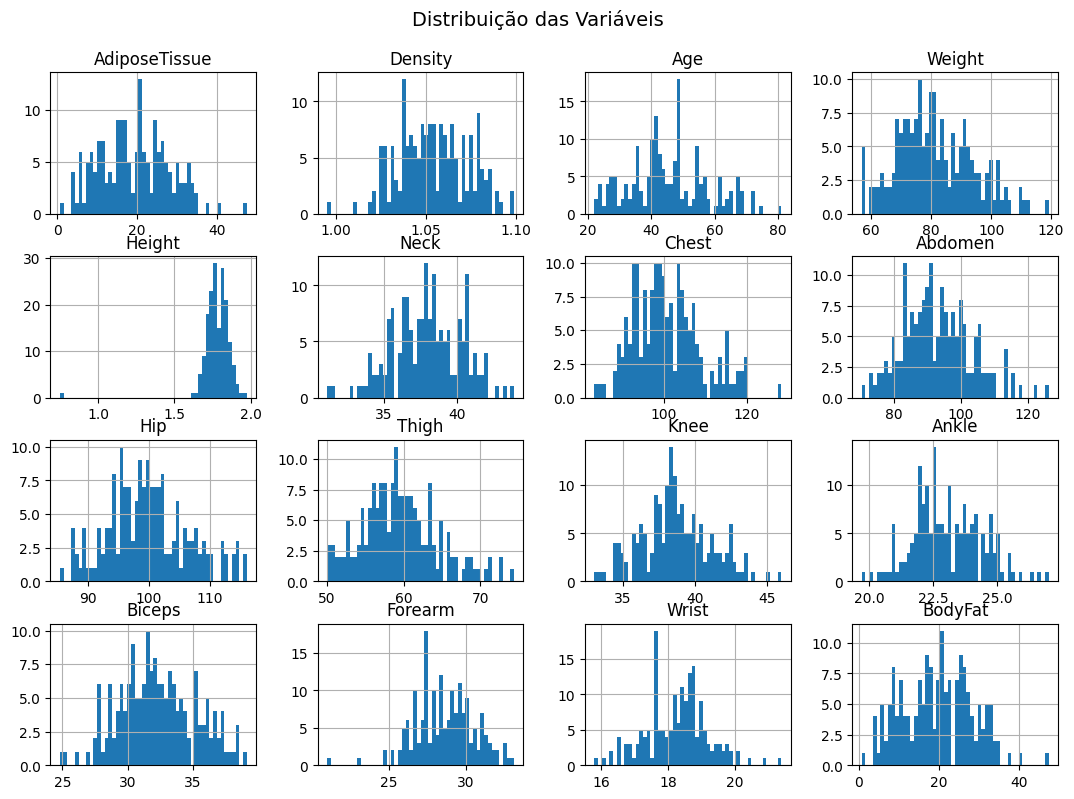

In [ ]:
df.hist(figsize=(13, 9), bins=50)
plt.suptitle('Distribuição das Variáveis', x=0.5, y=0.95, fontsize=14)
plt.show()

Como podemos ver, possuimos alguns outliers em nosso Dataset, vamos tratar esses dados de forma correta utilizando o IQR, com um range de no máximo 2xIQR

In [ ]:
before_rows = df.shape[0]

def remove_outliers_iqr(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR

    return data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]


for column in df.columns:
    df = remove_outliers_iqr(df, column)


filtered_rows = df.shape[0]
print("Antes", before_rows, " - Depois", filtered_rows)

Antes 175  - Depois 171


Após este tratamento, acabamos removendo 4 linhas, que é um valor aceitável para nosso Dataset.

Acabei não usando outra forma de tratar esses dados porque poderia acabar gerando algum BodyFat totalmente irreal.

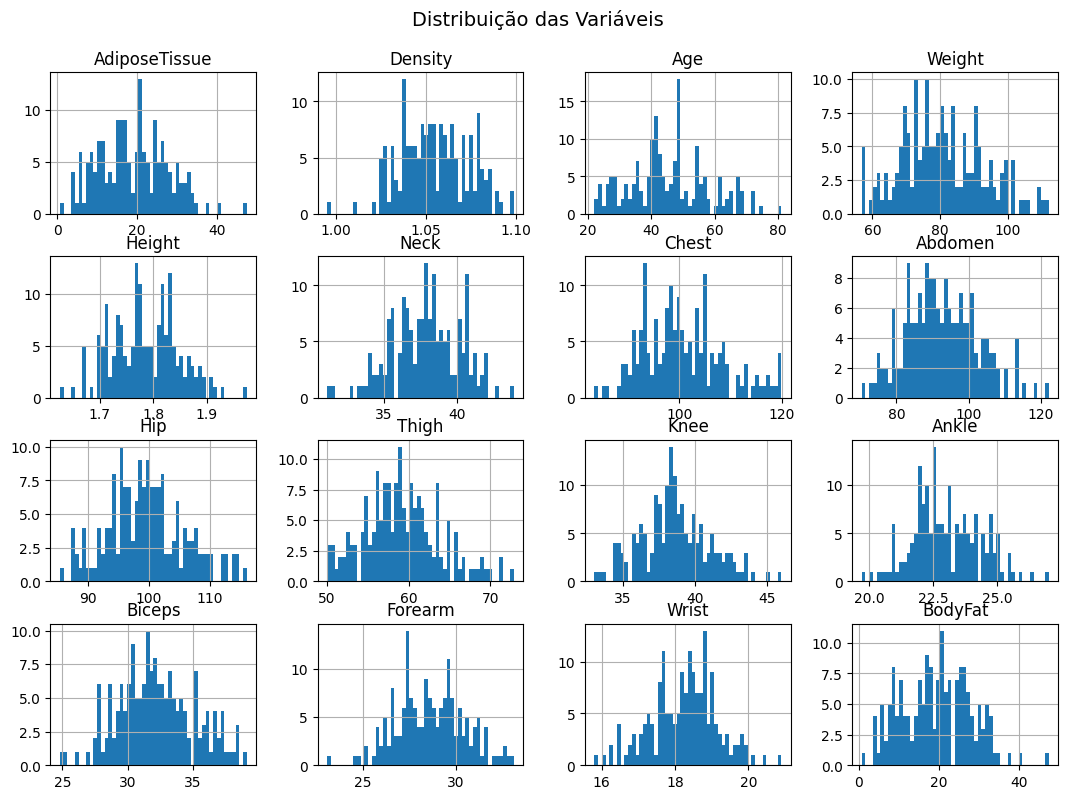

In [ ]:
df.hist(figsize=(13, 9), bins=50)
plt.suptitle('Distribuição das Variáveis', x=0.5, y=0.95, fontsize=14)
plt.show()

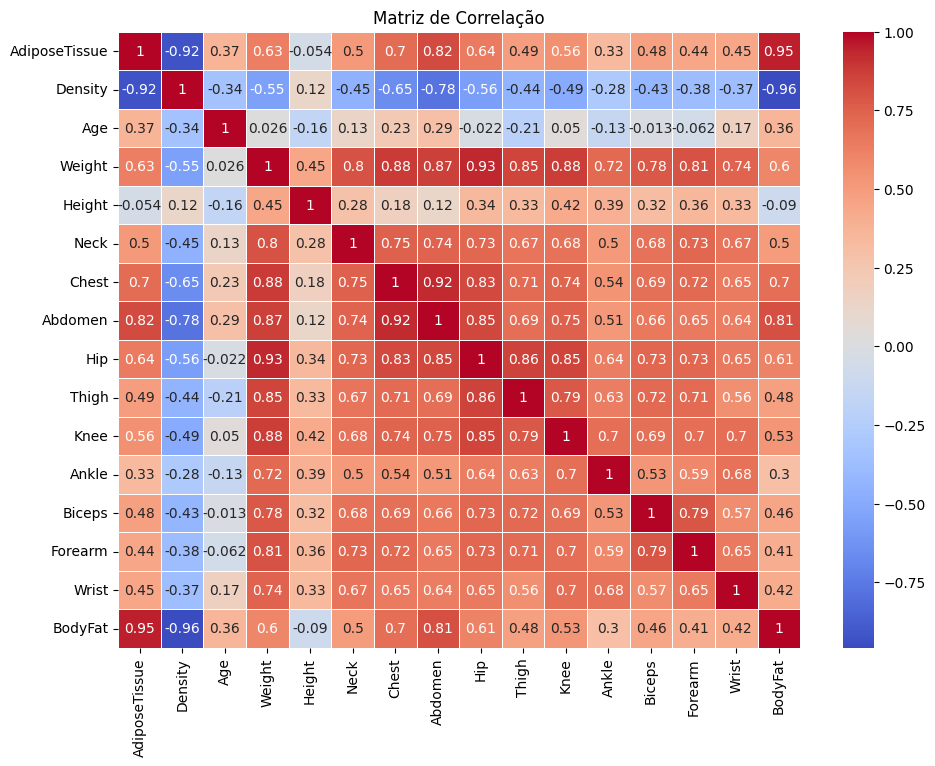

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(11, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Matriz de Correlação")
plt.show()

Após essa Matriz de Correlação, algumas coisas foram descobertas, por exemplo, é percebido quais variáveis possuem maior relação e importância para o resultado de BodyFat, como Density, Abdomen, Chest e Weight, e outras que não tem tanta relevância como Ankle, Forearm e Wrist, para podermos dar andamento com esse treinamento, podemos retirar algumas colunas que não possuem tanta relação como foi dito anteriormente, porém, é necessário que essa abordagem faça sentido, então vamos pesquisar sobre.

**Pesquisei sobre a relação entre essas colunas com a target, e se as mesmas possuem influência no resultado, esta foi a resposta do GPT4:**

*Circunferência do Antebraço: Normalmente não é usada para avaliar a gordura corporal, pois a área é mais influenciada pela densidade muscular e óssea.*

*Circunferência do Pulso: Às vezes, é considerada nas avaliações do tamanho da estrutura corporal. Não é uma medida direta de gordura corporal, mas pode ter uma relação indireta.*

*Circunferência do Tornozelo: Não é comumente associada à medição da gordura corporal, mas pode refletir o tamanho geral do corpo e problemas como retenção de líquidos.*

Então, a partir dessas afirmações, podemos retirar essas variáveis de nosso Dataset.

In [ ]:
df['IMC']=df['Weight']/(df['Height']*df['Height'])
df.drop(columns=['Ankle','Wrist','Forearm'], inplace=True)

df.head()

,AdiposeTissue,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Biceps,BodyFat,IMC
0,29.9,1.0316,65.0,86.070035,1.67005,40.8,106.4,100.5,100.5,60.85,38.1,35.9,29.9,30.859795
1,27.0,1.0378,72.0,76.204300,1.75895,38.5,101.4,99.8,96.2,56.30,36.6,29.7,27.0,24.630458
2,8.8,1.0790,29.0,72.915722,1.75260,36.7,97.4,83.5,98.7,58.90,35.3,30.1,8.8,23.738625
4,20.3,1.0525,35.0,101.945931,1.83515,43.9,109.0,100.4,106.8,63.30,41.7,37.2,20.3,30.271000
5,26.7,1.0384,58.0,73.369319,1.79705,35.1,97.4,94.9,100.2,56.30,35.9,27.8,26.7,22.719259


## **Model Training**

Então vamos realizar o treinamento do modelo, primeiramente vamos escolher um modelo para trabalharmos e utilizar uma técnica para transformação de nossas variáveis, a escolhida foi a Power Transform, essa foi a escolha devido a Power Transform ser uma técnica com resultados positivos para variáveis que não seguem uma distribuição normal, ou, que apresentam desvio da normalidade, visto que esse é o nosso caso, decidi utilizar a mesma.

In [ ]:
X = df.drop(columns=['BodyFat'])
y = df['BodyFat']

pt = PowerTransformer()
X2_train = pt.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X2_train, y, test_size=0.3, random_state=1)

Para nosso modelo de Machine Learning, decidi utilizar os modelos Ridge e Lasso, visto que ambos possuem resultados e aplicações parecidas, então, vamos aos motivos de utilizar estes modelos, como sabemos são modelos lineares e também possuem resultados positivos para não gerar overfitting, já para utilização de Ridge também temos uma questão positiva, o mesmo é melhor utilizado quando queremos lidar com Multicolinearidade, que é o caso de nosso Dataset, e já para Lasso, temos uma questão positiva que é a capacidade do modelo de escolher atributos, utilizando somente as variáveis realmente importantes para o treinamento.

In [ ]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.1)

In [ ]:
ridge_cv_mse = np.mean(cross_val_score(ridge_model, X2_train, y, scoring='neg_mean_squared_error', cv=5))
lasso_cv_mse = np.mean(cross_val_score(lasso_model, X2_train, y, scoring='neg_mean_squared_error', cv=5))

## **Results**

In [ ]:
ridge_predictions = ridge_model.predict(X_test)
lasso_predictions = lasso_model.predict(X_test)

### Results Ridge

In [ ]:
mse_ridge = mean_squared_error(y_test, ridge_predictions)
print("Mean Squared Error (MSE):", mse_ridge)

rmse_ridge = np.sqrt(mse_ridge)
print("Root Mean Squared Error (RMSE):", rmse_ridge)

mae_ridge = mean_absolute_error(y_test, ridge_predictions)
print("Mean Absolute Error (MAE):", mae_ridge)

r2_ridge = r2_score(y_test, ridge_predictions)
print("R2 Score:", r2_ridge)

Mean Squared Error (MSE): 2.422773662234118
Root Mean Squared Error (RMSE): 1.5565261521202007
Mean Absolute Error (MAE): 0.8963339368086842
R2 Score: 0.9513413806184098


### Results Lasso

In [ ]:
mse_lasso = mean_squared_error(y_test, lasso_predictions)
print("Mean Squared Error (MSE):", mse_lasso)

rmse_lasso = np.sqrt(mse_lasso)
print("Root Mean Squared Error (RMSE):", rmse_lasso)

mae_lasso = mean_absolute_error(y_test, lasso_predictions)
print("Mean Absolute Error (MAE):", mae_lasso)

r2_lasso = r2_score(y_test, lasso_predictions)
print("R2 Score:", r2_lasso)

Mean Squared Error (MSE): 2.282923083772855
Root Mean Squared Error (RMSE): 1.5109345067781248
Mean Absolute Error (MAE): 0.7853909426608051
R2 Score: 0.9541501184603784


Então temos os resultados de ambos os treinamentos de Ridge e Lasso, e como podemos ver, o modelo Lasso possui resultados mais positivos se comparado com Ridge já que possui todos os scores com valores menores, como **MSE**, que determina que quanto menor o valor, mais as previsões do modelo estão próximas aos valores reais, como Lasso possui um valor menor, logo possui um resultado melhor, também podemos ver isso no **R2 Score**, onde seu valor se aproxima de mais de 1, logo determina que o modelo se ajustou mais positivamente aos dados.